# Projet de modélisation statistique - Graphes bipartis

In [1]:
import numpy as np
import random as rd
from numpy.random import permutation
import networkx as nx
from networkx.algorithms import bipartite
import time
from random import seed
import tqdm as tqdm

from benchmark import main4
from benchmark import main3
from benchmark import main2

import matplotlib.pyplot as plt
from IPython.display import HTML, display


## I - Présentation

### 1) Graphe biparti

Un graphe biparti est composé de deux parties : un ensemble de ressources $U$ et un ensemble de demandes $V$. Ces deux parties sont composées de sommets contenant chacun une ou plusieurs demi-arêtes disponibles qui définissent le degré du sommet. Une demi-arête dans $U$ peut être reliée à une demi-arête dans $V$ pour former une arête. On définit alors un graphe biparti par le couple $(U \cup V, \mathcal{E})$ où $\mathcal{E} \subset U \times V$ est un ensemble d'arêtes.

Le graphe biparti trouve de nombreuses applications, par exemple dans le cas de campagnes de publicité.

L'objectif est de trouver l'allocation optimale. Pour cela, il convient de definir la notion de match. Un match $M$ est un sous-ensemble d'arêtes de $\mathcal{E}$ tel que chaque sommet $v \in V$ soit le point d'arrivée d'au plus une arête. On peut définir la qualité d'un match comme la quantité d'arêtes qu'il contient, c'est à dire $\lvert M \rvert$. Pour un graphe biparti donné, on note $M^*$ le match (ou l'un des matchs) atteignant le cardinal le plus élevé.

Des algorithmes peuvent alors être implémentés et leurs résultats peuvent être évalués. Pour un match $M$ obtenu, on définit le ratio de compétitivité par $\frac{\lvert M \rvert}{\lvert M^* \rvert}$.

Pour ce projet, nous allons implémenter et étudier le comportement de deux algorithmes très classiques : Greedy et Ranking.

### 2) Algorithme greedy

L'algorithme greedy est l'algorithme le plus simple. Son principe est le suivant :
- On considère $d^U$ une liste de taille $N$ contenant la capacité des $N$ sommets de $U$. De même avec $d^V$ liste de taille $T$ qui contient la capacité des $T$ sommets de $V$.
- Pour chaque sommet $v$ de $V$, pour chaque demi-arête de $v$, on séletionne au hasard une demi-arête $e_i^U$ d'un sommet de $U$ qui n'a pas déjà été appariée.
- Si $v$ n'a pas encore été appariée et si le sommet de la demi-arête $e_i^U$ n'a pas non plus été aparié, alors on aparie ces deux sommets (donc on crée une arête) et on rentre cet appariement dans l'ensemble des appariement trouvés $M$.

Ainsi cet algorithme permet d'obtenir un match $M$. Voici un pseudo-code de cet algorithme (Noiry & al.) :

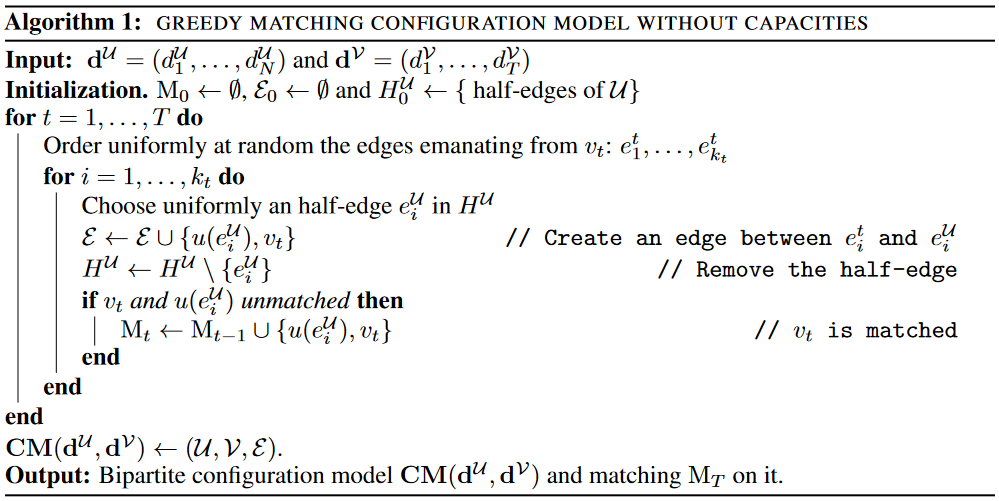

Voici son code:

In [2]:
def gready(d_U,d_V, affichage = False):
    #input :  two sequences5 of nonnegative integers
    #d_U de taille N = degrés des sommet de U c'est à dire le nombre de demi arrete que comporte chaque somment de U
    #d_V de taille T = degrés des sommets de V
    N=len(d_U)
    T=len(d_V)
    M=[]
    eps=[]
    #H0=half edges de U
    H=d_U[:]
    ##### Pour le tracé #####
    U=["L"+str(i) for i in range(len(d_U))]
    V=["R"+str(i) for i in range(len(d_V))]
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0)
    G.add_nodes_from(V,bipartite=1)
    ########################
    for t in range(T): #attention aux indices
        #Pt=permutation(np.arrange(d_V[t]))
        #on considère que les aretes d'un meme sommet sont interchangeables   
        for i in range(d_V[t]):
            nb_aretes_dispo=np.sum(H)
            #sert à selectionner une demi-arete uniformément dans les demi-aretes encore dispo de U
            if nb_aretes_dispo>0:
                curseur = rd.randrange(1,nb_aretes_dispo+1)
                res=0
                i=0
                while res<curseur:
                    res+=H[i]
                    i+=1
                i-=1 #c'est le sommet de la demi arrete encore dispo de U qu'on selectionne 
                eps.append(("L"+str(i),"R"+str(t)))#on rajoute la nouvelle arete a la liste des aretes 
                H[i]-=1 #on rend la demi-arete de U indisponible
                if "L"+str(i) not in M :
                    if "R"+str(t) not in M:
                        M.append("L"+str(i))
                        M.append("R"+str(t))
                G.add_edges_from(eps)
                if affichage :
                    nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, U), width = 2)
    return (eps,M)

### 3) Algorithme ranking

L'algorithme ranking est légèrement plus sophistiqué que le précédant et le surperforme en général. Voici son fonctionnement :
- On considère $d^L$ une liste de taille $N$ contenant la capacité des $N$ sommets de $U$. De même avec $d^R$ liste de taille $T$ qui contient la capacité des $T$ sommets de $V$.
- On associe une valeur aléatoire $Y_i$ tirée dans $[0, 1]$ pour chaque sommet $i$ de $U$.
- Pour chaque sommet $v$ de $V$, on considère tous les sommets de $U$ qui n'ont jamaise été appariés. Pour chaque sommet $i$ de $U$, on calcule $v_i(1-g(Y_i))$ avec $v_i$ le nombre de demi-arêtes du sommet $i$ et $g$ la fonction définie par $g(y) = e^{y-1}$.
- Le sommet $i$ qui obtient la valeur la plus importante est apparié à $v$ et on ajoute cet appariement à $M$ (comme pour l'algorithme greedy.

Ce fonctionnement est détaillé dans le pseudo code ci-dessous (Devanur & al.) :

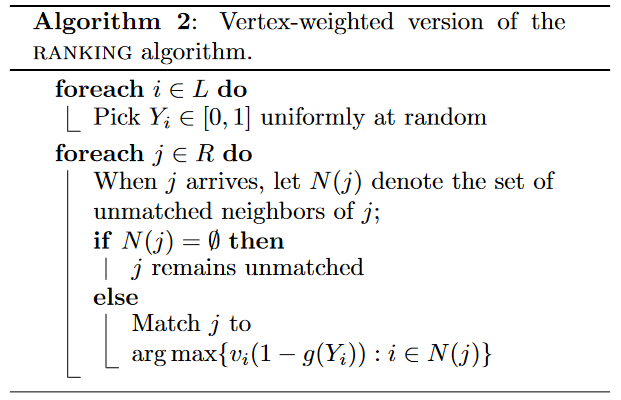

Voici son code :

In [3]:
def ranking(d_L,d_R, affichage = False):
    #input :  two sequences5 of nonnegative integers
    #d_U de taille N = degrés des sommet de U c'est à dire le nombre de demi arrete que comporte chaque somment de U
    #d_V de taille T = degrés des sommets de V
    N=len(d_L)
    T=len(d_R)
    L = [rd.random() for i in range(N)]
    M=[]
    eps=[]
    H=d_L[:]
    ##### Pour le tracé #####
    U=["L"+str(i) for i in range(len(d_L))]
    V=["R"+str(i) for i in range(len(d_R))]
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0)
    G.add_nodes_from(V,bipartite=1)
    ########################
    for t in range(T): #attention aux indices
        #on considère que les aretes d'un meme sommet sont interchangeables
        nb_aretes_dispo=np.sum(H)
        if nb_aretes_dispo>0:
            res=0
            curseur = 0
            for j in range (len(H)): #On détermine à quel sommet on rattache le sommet t
                a = H[j]*(1-np.exp(L[j]-1))
                if a>res:
                    res = a
                    curseur = j
            eps.append(("L"+str(curseur),"R"+str(t)))#on rajoute la nouvelle arete a la liste des aretes
            H[curseur]-=1 #on rend la demi-arete de L indisponible
            if "L"+str(curseur) not in M:
                if "R"+str(t) not in M:
                    M.append("L"+str(curseur))
                    M.append("R"+str(t))
    G.add_edges_from(eps)
    if affichage:
        nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, U), width = 2)
    return (eps,M)

In [4]:
d_U=[2,3,1,3]
d_V=[2,1,2]

#d_U=[2,1,2,1]
#d_V=[2,4,3]

#U=["L"+str(i) for i in range(len(d_U))]
#V=["R"+str(i) for i in range(len(d_V))]


#test = ranking([rd.randint(1, 3) for x in range(2)],[rd.randint(1, 3) for x in range(3)])
test = ranking(d_U,d_V)
print(test)

([('L1', 'R0'), ('L2', 'R1'), ('L1', 'R2')], ['L1', 'R0', 'L2', 'R1'])


## II - Étude du comportement des algorithmes

### II-1) Étude du ratio de compétitivité 

On va maintenant comparer nos deux algorithmes sur différents indicateurs de performance. On peut en effet juger de la qualité d'un matching dans un graphe bipartite en évaluant le ratio de compétitivité défini plus haut. Ici nous étudierons une version simplifiée du ratio de compétitivité en s'intéressant plutôt au nombre de matching réalisés par notre algorithme divisé par le nombre de sommet dans notre graphe : $\frac{\lvert M \rvert}{\lvert n+m \rvert}$
avec : 
- $M$ le nombre de matching réalisé par notre algorithme (ie le nombre de sommets qui est au moins relié à un autre sommet)
- $n$ le nombre de sommets à gauche dans notre graphe bipartite 
- $m$ le nombre sommets à droite dans notre graphe bipartite

On va donc comparer dans un premier temps nos graphes en étudiant l'évolution du ratio de compétitivité modifié en faisant varier tantôt la taille du graphe tantôt la capacité de chaque sommet (ie le paramètre $d$: le nombre de demi arrêtes que contiennent les sommets).


#### II-1-a) Ratio de compétitivité en fonction de la capacité 

In [5]:
#main4()

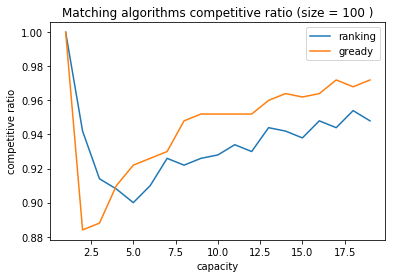

Ici on va donc faire tourner le code sur un d-graphe régulier de taille (100,100). Pour chaque capacité (prise entre $d=1$ et $d=9$ ici) on fait tourner 10 fois le code et on prend la moyenne des ratios de compétitivité obtenus. 

On constate un premier résultat qui peut sembler étonnant : Greedy est meilleur que ranking en terme de ratio de compétitivité à partir d'une certaine capacité vers $d=4$.

#### II-1-b) Ratio de compétitivité en fonction de la taille du graphe

In [6]:
#main3()

A|B
-|-
![alt](Images/Image1.png)|![alt](Images/Image2.png)


Pour tester nous avons ici tracer le ratio de compétitivité en fonction de la taille des d-graphes (en faisant varier le nombre de sommets des deux côtés en même temps) à capacité fixée dans les deux cas suivants : 

- $d=10$ dans le premier cas. Cela signifie que chaque sommet du graphe aura 10 demi arrêtes au maximum. Avec les résultats de la partie précédente, on aurait intuité que greedy serait meilleur dans ce cas-ci peu importe la taille du graphe. Ce résultat se confirme pour des tailles à partir de (20,20). Pour des tailles plus petites, les algorithmes proposent des matchings de qualité comparable. 
- $d=2$ dans le deuxième cas. Avec les résultats de la partie précédente on aurait intuité que ranking serait meilleur dans ce cas et c'est bien ce que l'on retrouve ici. 

### II-2) Étude annexe du temps d'exécution

Tout en ayant conscience que le temps d'exécution des algorithmes dépend fortement de la manière dont on implémente les dits algorithmes, nous avons voulu par curiosité comparer nos deux algorithmes sur ce critère. En effet un algorithme qui est très couteux en temps n'est pas souhaitable. 

#### II-2-a) Temps d'exécution en fonction de la capacité

In [7]:
#main2()

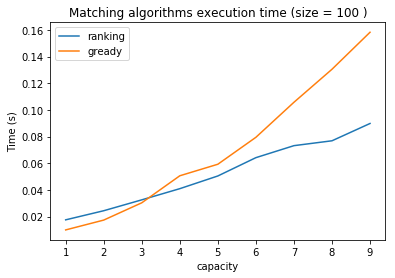

Ici on va donc faire tourner le code sur un d-graphe régulier de taille (100,100). Pour chaque capacité (prise entre  𝑑=1  et  𝑑=9  ici) on fait tourner 10 fois le code et on prend la moyenne des temps d'exécutions obtenus.

On constate que Ranking est meilleur que Greedy en terme de temps d'exécution à partir d'une certaine capacité vers  𝑑=3. Cela semble assez cohérent avec le fait que Greedy soit un algorithme coûteux puisqu'il parcourt l'ensemble des demi-arêtes du sous-graphe de gauche à chaque fois qu'un nouveau sommet arrive à droite pour en sélectionner une au hasard. D'un autre côté ranking parcourt seulement les sommets disponnibles à gauche et les tri. 

#### II-2-b) Temps d'exécution en fonction de la capacité

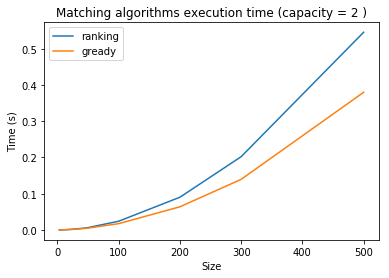

Ici on va donc faire tourner le code sur un 2-graphe régulier de taille (n,n) pour n variant entre 0 et 500. Pour chaque taille de graphe on fait tourner 10 fois le code et on prend la moyenne des temps d'exécutions obtenus.
Contrairement à précédement ici c'est Greedy qui semble meilleur que Ranking. 